**cVAE (conditional)**

General Imports

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

Global Constants

In [13]:
train_path = 'mnist_train.csv'
test_path = 'mnist_test.csv'

LATENT_DIM = 20

Data Processing

In [14]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, label=None): #label filters input (label!=None is a VAE on unlabeled data)
        data = pd.read_csv(csv_file)
        self.X = data.drop('label', axis=1).values / 255. #normalize pixel values
        self.y = torch.tensor(data['label'].values)
        self.y_one_hot = F.one_hot(self.y, num_classes=10).float() #one-hot encoding

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), self.y_one_hot[idx]

#Load data from csv files (remove 'label' for entire dataset)
train_data = MNISTDataset(train_path, label=None)
test_data = MNISTDataset(test_path,label=None)

#data loaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Model

In [15]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(784 + 10, 400) #take both data and labels
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20 + 10, 400) #take both latent variable and labels
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x, y):
        h1 = F.relu(self.fc1(torch.cat((x, y), axis=1)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h3 = F.relu(self.fc3(torch.cat((z, y), axis=1)))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 784), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

Loss (ELBO)

In [16]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') #entropy (binary cross)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #divergence (KL)
    return BCE + KLD

Training Loop

In [17]:
def train_vae(vae, epochs):
    start = time.time() #progress
    num_iterations = int(np.ceil(len(train_data) / batch_size))
    print('Total batches per epoch: {}'.format(num_iterations))
    epoch_losses = [] #tracking convergence

    for epoch in range(1, epochs + 1):
        print('Epoch {}'.format(epoch)) #progress
        vae.train()
        train_loss = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data, labels
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        end = time.time() #progress
        print('Epoch complete in {} s'.format(end-start))
        avg_loss = train_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_loss))
        
    end = time.time()
    print('Training complete in {} s'.format(end-start))
    return epoch_losses

Sample Generation

In [18]:
def generate_sample(vae, label):
    with torch.no_grad():
        z = torch.randn(1, 20)
        label_one_hot = F.one_hot(torch.tensor([label]), num_classes=10).float()
        sample = vae.decode(z, label_one_hot)
        sample = sample.view(28, 28).cpu().numpy()

        plt.figure(figsize=(2, 2))
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.show()

In [19]:
def generate_9_samples(vae, label):
    '''
    format for written report
    '''
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    
    for i in range(3):
        for j in range(3):
            with torch.no_grad():
                z = torch.randn(1, 20)
                label_one_hot = F.one_hot(torch.tensor([label]), num_classes=10).float()
                sample = vae.decode(z, label_one_hot)
                sample = sample.view(28, 28).cpu().numpy()

                axes[i, j].imshow(sample, cmap='gray')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

Implementation - Training

Total batches per epoch: 3750
Epoch 1
Epoch complete in 25.49307918548584 s
====> Epoch: 1 Average loss: 127.0653
Epoch 2
Epoch complete in 60.61420154571533 s
====> Epoch: 2 Average loss: 109.0138
Epoch 3
Epoch complete in 98.57262539863586 s
====> Epoch: 3 Average loss: 106.0815
Epoch 4
Epoch complete in 137.5900046825409 s
====> Epoch: 4 Average loss: 104.5541
Epoch 5
Epoch complete in 176.7178497314453 s
====> Epoch: 5 Average loss: 103.6391
Epoch 6
Epoch complete in 215.98776292800903 s
====> Epoch: 6 Average loss: 102.8452
Epoch 7
Epoch complete in 254.74650764465332 s
====> Epoch: 7 Average loss: 102.3297
Epoch 8
Epoch complete in 293.7377803325653 s
====> Epoch: 8 Average loss: 101.8767
Epoch 9
Epoch complete in 333.4272289276123 s
====> Epoch: 9 Average loss: 101.5081
Epoch 10
Epoch complete in 374.408891916275 s
====> Epoch: 10 Average loss: 101.2156
Training complete in 374.4089958667755 s


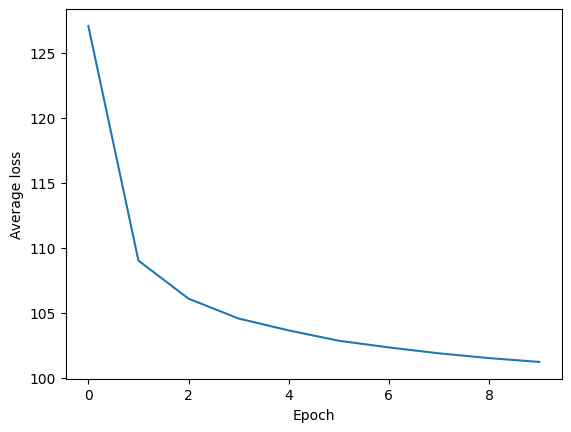

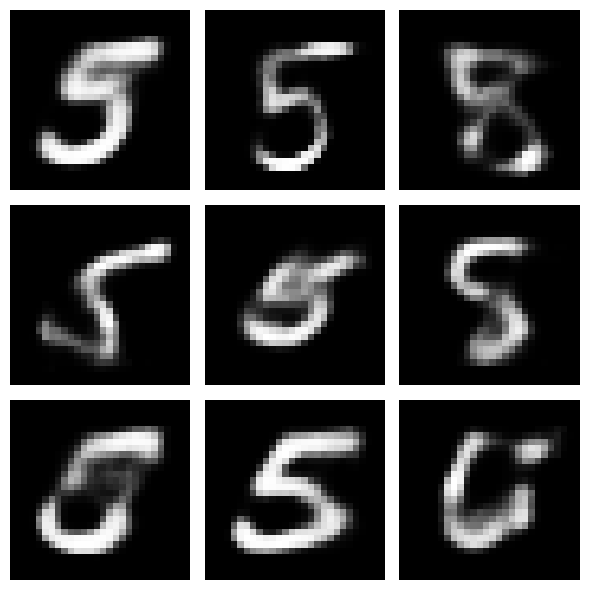

In [20]:
cvae = CVAE()
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

EPOCHS=10
losses = train_vae(cvae, epochs=EPOCHS)
plt.plot(range(EPOCHS),losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()
generate_9_samples(cvae, 5)

Implementation - Sample Generation

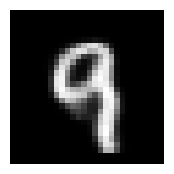

In [21]:
generate_sample(cvae,label=9)